In [212]:
#!pip install openpyxl
#https://clio-infra.eu/Indicators/Height.html

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

pd.options.mode.chained_assignment = None
df_var = pd.read_excel('other_data/LifeExpectancyatBirth(Total)_Compact.xlsx', sheet_name='Data Long Format')
df_var


/Users/charlesdedampierre/Desktop/cultura_project/.venv/lib/python3.11/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,ccode,country.name,year,value
0,826,United Kingdom,1543,33.94
1,826,United Kingdom,1548,38.82
2,826,United Kingdom,1553,39.59
3,826,United Kingdom,1558,22.38
4,826,United Kingdom,1563,36.66
...,...,...,...,...
12858,792,Turkey,2011,74.60
12859,826,United Kingdom,2011,80.80
12860,840,United States,2011,78.70
12861,484,Mexico,2012,74.40


<Axes: >

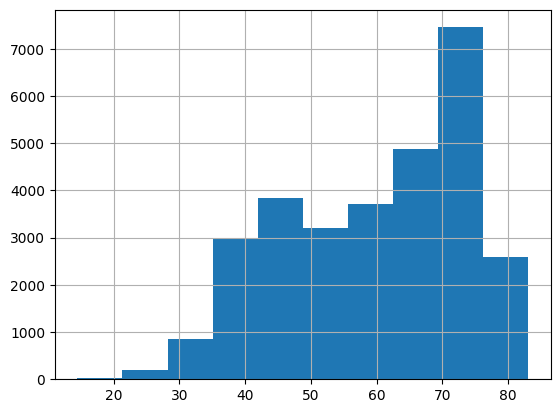

In [213]:

var = 'life_expectancy'

df_var = df_var.rename(columns={'value':var, 'country.name':'name'})
df_var = df_var.sort_values(var, ascending=False)


df_var = df_var.drop('name', axis=1)
df_ccode_iso = pd.read_csv('other_data/ccode_iso3.csv')
df_ccode_iso = df_ccode_iso[['name', 'country-code', 'alpha-3']]
df_ccode_iso.columns = ['name', 'ccode', 'iso_a3'].copy()

df_var = pd.merge(df_var, df_ccode_iso, on = 'ccode')

# load regions and equivalent country_name
df_regions_culture = pd.read_csv('other_data/ENS - Cultural Index - Countries Databases - consolidate_table.csv')
df_regions_culture = df_regions_culture[['region', 'iso_a3']].drop_duplicates()

df_var = pd.merge(df_var, df_regions_culture, on = 'iso_a3')
df_var = df_var.rename(columns={'name':'country_name'})
#df_var[var]=df_var[var] + abs(min(df_var[var]))

# Normalize the wellbeing column
# min_val = df_var[var].min()
# max_val = df_var[var].max()

# df_var[var] = (df_var[var] - min_val) / (max_val - min_val)

# df_var = df_var[df_var['wellbeing']>0]
df_var[var].hist()


### Population (Maddison + Interpolation for every year)

In [214]:
df_population_interpolated = pd.read_csv('other_data/population_interpolated.csv', index_col=[0])
df_iso = pd.read_csv('other_data/iso.csv', index_col = [0])
df_population_interpolated = pd.merge(df_population_interpolated, df_iso, on = 'country_name')
df_population_interpolated

,country_name,year,pop,iso_a3
0,Albania,1,200.0,ALB
1,Albania,2,200.0,ALB
2,Albania,3,200.0,ALB
3,Albania,4,200.0,ALB
4,Albania,5,200.0,ALB
...,...,...,...,...
79336,Viet Nam,1896,10528.0,VNM
79337,Viet Nam,1897,10528.0,VNM
79338,Viet Nam,1898,10528.0,VNM
79339,Viet Nam,1899,10528.0,VNM


In [215]:
var_weighted = f'{var}_weighted'

df_var_pop = pd.merge(df_var, df_population_interpolated, on = ['year','iso_a3'])

df_var_w = df_var_pop.groupby(['region', 'year']).apply(lambda x: (x[var] * x['pop']).sum() / x['pop'].sum())
df_var_w = df_var_w.reset_index()
df_var_w = df_var_w.rename(columns={0: var_weighted})
df_var_w = df_var_w[df_var_w['year']<=1880]

df_var_w['decade'] = df_var_w['year'].apply(lambda x: round(x / 10) * 10)
df_var_w = df_var_w.groupby(['region', 'decade'])[var_weighted].mean().reset_index()
df_var_w.to_csv('other_data/f{var}_weighted_pop_decade.csv')

### Visualize

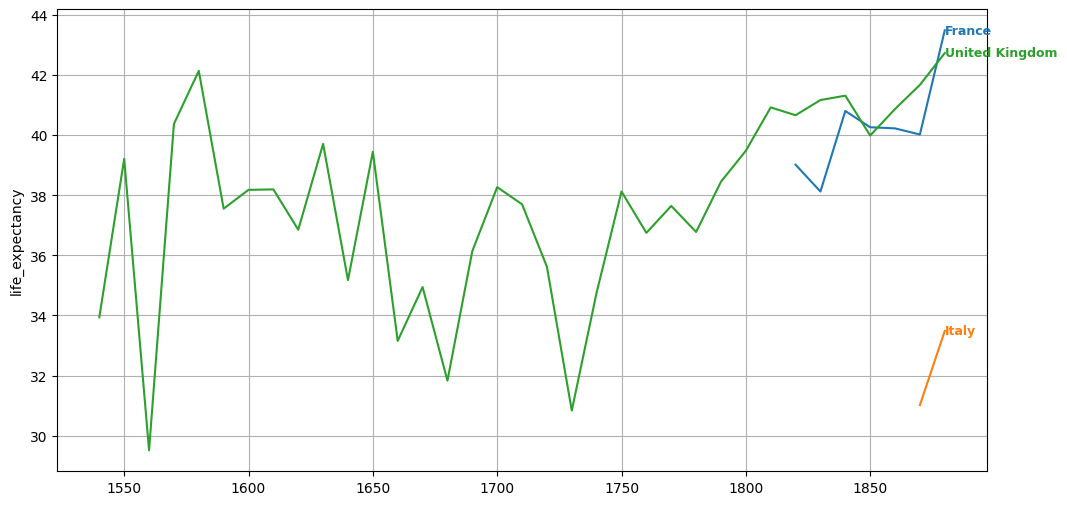

In [216]:
import matplotlib.pyplot as plt

df_fig = df_var_w[df_var_w['region'].isin(['France', 'Italy', 'Chinese world', 'United Kingdom', 'Arabic world'])]

# Re-plotting with country labels near each line
plt.figure(figsize=(12, 6))

for region in df_fig['region'].unique():
    subset = df_fig[df_fig['region'] == region]
    line = plt.plot(subset['decade'], subset[var_weighted], label=region)  # Store the line object
    
    # Get the color of the line
    line_color = line[0].get_color()  # Get the color of the first line (since the plot returns a list)
    
    # Adding text label near the end of each line with the same color as the line
    plt.text(subset['decade'].values[-1], subset[var_weighted].values[-1], region, 
             verticalalignment='center', fontsize=9, weight='bold', color=line_color)

# Adding plot details
plt.title("")
plt.xlabel("")
plt.ylabel(var)
plt.grid(visible=True)

plt.show()

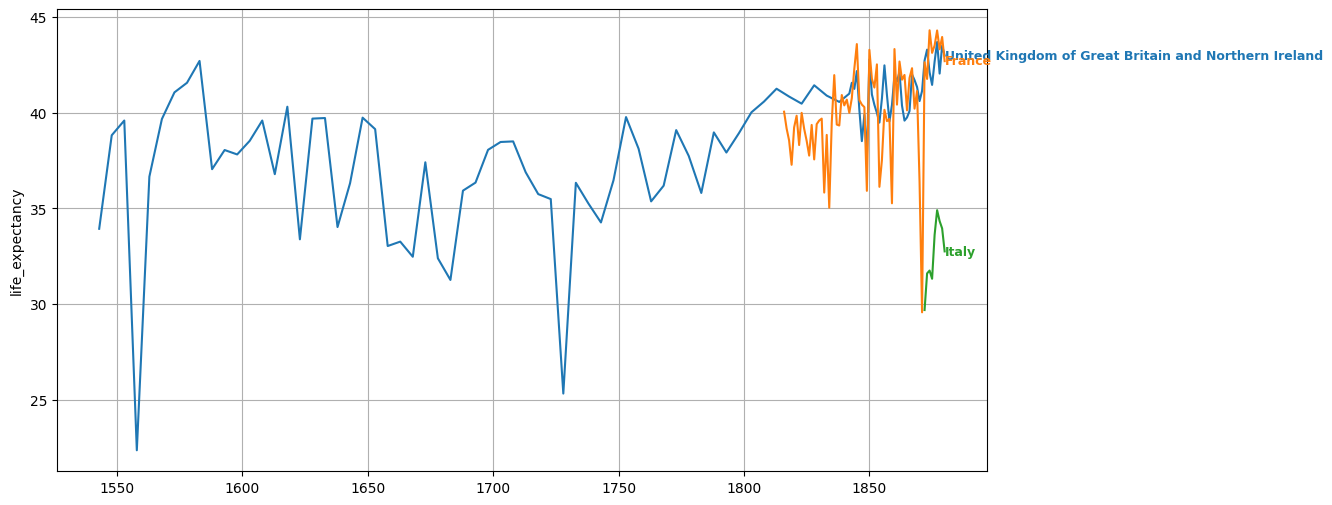

In [217]:
import matplotlib.pyplot as plt

df_fig = df_var[['year', 'country_name', var]].drop_duplicates()
df_fig = df_fig[df_fig['country_name'].isin(['France', 'Italy', 'China', 'United Kingdom of Great Britain and Northern Ireland'])]
df_fig = df_fig.sort_values(['year', 'country_name'])
df_fig = df_fig[df_fig['year']<=1880]


# Re-plotting with country labels near each line
plt.figure(figsize=(12, 6))

for region in df_fig['country_name'].unique():
    subset = df_fig[df_fig['country_name'] == region]
    line = plt.plot(subset['year'], subset[var], label=region)  # Store the line object
    
    # Get the color of the line
    line_color = line[0].get_color()  # Get the color of the first line (since the plot returns a list)
    
    # Adding text label near the end of each line with the same color as the line
    plt.text(subset['year'].values[-1], subset[var].values[-1], region, 
             verticalalignment='center', fontsize=9, weight='bold', color=line_color)

# Adding plot details
plt.title("")
plt.xlabel("")
plt.ylabel(var)
plt.grid(visible=True)
plt.show()


### Correlation with the PCI

In [218]:
### Load CPI
path = 'unseen_species_model/unseen_species_model_bayesian.csv'

df_cultura = pd.read_csv(path, index_col = [0])
df_cultura['N_est'] = df_cultura['f0'] + df_cultura['f1'] + df_cultura['f2']# plus the individual
df_cultura = df_cultura.groupby(['region_name', 'decade']).agg({'N_est': 'sum', 'individual_wikidata_id':'count'}).reset_index()
df_cultura = df_cultura.rename(columns={"individual_wikidata_id": "score"})
df_cultura.head(10)


,region_name,decade,N_est,score
0,Arabic world,-610,5.529170,1
1,Arabic world,-400,2.611448,1
2,Arabic world,-360,14.825990,3
3,Arabic world,-330,6.061846,1
4,Arabic world,-310,6.022250,1
5,Arabic world,-300,24.011958,4
6,Arabic world,-280,5.966345,1
7,Arabic world,-270,23.797637,4
8,Arabic world,-260,11.867531,2
9,Arabic world,-250,5.919737,1


In [219]:
df_var_w = df_var_w.rename(columns={"region": "region_name"})
df = pd.merge(df_var_w, df_cultura, on = ['region_name', 'decade'])
df = df.rename(columns = {'decade': 'year'})
df.head(10)


,region_name,year,life_expectancy_weighted,N_est,score
0,France,1820,39.012000,12611.867746,813
1,France,1830,38.118889,12294.782460,903
2,France,1840,40.796364,22397.642731,1556
3,France,1850,40.255556,22275.014487,1527
4,France,1860,40.218182,29344.996514,1955
5,France,1870,40.014444,21566.526049,1432
6,France,1880,43.478333,32132.232209,2090
7,German world,1870,34.400000,76415.858224,2255
8,German world,1880,40.505000,114863.333050,3538
9,Greek World,1820,39.012000,303.874182,17


In [220]:


list(set(df.region_name))
df.region_name.value_counts()

keep = ['Indian world',
 'Nordic countries',
 'Persian world',
 'Portugal',
 'United Kingdom',
 'France',
 'Greek World',
 'Arabic world',
 'Chinese world',
 'Japan',
 'German world',
 'Low countries',
 'Italy',
 'Korea',
 'Spain']

# Apply normalization

df["century"] = df["year"].round(-2)
df["score_log"] = np.log(df["score"])
df["N_est_log"] = np.log(df["N_est"])
df["score_log_std"] = df["score_log"] / df["score_log"].mean()
df["N_est_std"] = df["N_est"] / df["N_est"].mean()
df["N_est_log_std"] = df["N_est_log"] / df["N_est_log"].mean()
df[f"log_{var}"] = np.log(df[f"{var}_weighted"])
df[f"log_{var}_std"] = df[f"log_{var}"] / df[f"log_{var}"].mean()
df[f"{var}_std"] = df[f"{var}_weighted"] / df[f"{var}_weighted"].mean()

df = df[df['region_name'].isin(keep)]
df

,region_name,year,life_expectancy_weighted,N_est,score,century,score_log,N_est_log,score_log_std,N_est_std,N_est_log_std,log_life_expectancy,log_life_expectancy_std,life_expectancy_std
0,France,1820,39.012000,12611.867746,813,1800,6.700731,9.442394,1.146995,0.672970,1.078420,3.663869,1.008847,1.028701
1,France,1830,38.118889,12294.782460,903,1800,6.805723,9.416930,1.164966,0.656050,1.075512,3.640710,1.002470,1.005150
2,France,1840,40.796364,22397.642731,1556,1800,7.349874,10.016711,1.258111,1.195140,1.144013,3.708593,1.021162,1.075752
3,France,1850,40.255556,22275.014487,1527,1800,7.331060,10.011221,1.254891,1.188596,1.143386,3.695248,1.017487,1.061492
4,France,1860,40.218182,29344.996514,1955,1900,7.578145,10.286877,1.297186,1.565851,1.174869,3.694319,1.017232,1.060506
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113,United Kingdom,1840,41.305000,12298.471136,936,1800,6.841615,9.417230,1.171110,0.656247,1.075546,3.720984,1.024574,1.089164
114,United Kingdom,1850,39.981111,12344.101231,909,1800,6.812345,9.420934,1.166100,0.658682,1.075969,3.688407,1.015604,1.054255
115,United Kingdom,1860,40.862273,15480.038693,1144,1900,7.042286,9.647307,1.205460,0.826016,1.101823,3.710207,1.021606,1.077490
116,United Kingdom,1870,41.663889,11764.644742,912,1900,6.815640,9.372854,1.166664,0.627762,1.070478,3.729635,1.026956,1.098628


                Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: log_life_expectancy_std
No. Observations: 75      Method:             REML                   
No. Groups:       8       Scale:              0.0004                 
Min. group size:  2       Log-Likelihood:     172.2390               
Max. group size:  35      Converged:          Yes                    
Mean group size:  9.4                                                
-----------------------------------------------------------------------
                    Coef.   Std.Err.     z      P>|z|   [0.025   0.975]
-----------------------------------------------------------------------
Intercept           0.891      0.031   29.077   0.000    0.831    0.951
N_est_log_std       0.110      0.028    3.909   0.000    0.055    0.164
Group Var           0.001      0.033                                   



/Users/charlesdedampierre/Desktop/cultura_project/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


(0.0, 1.0, 0.0, 1.0)

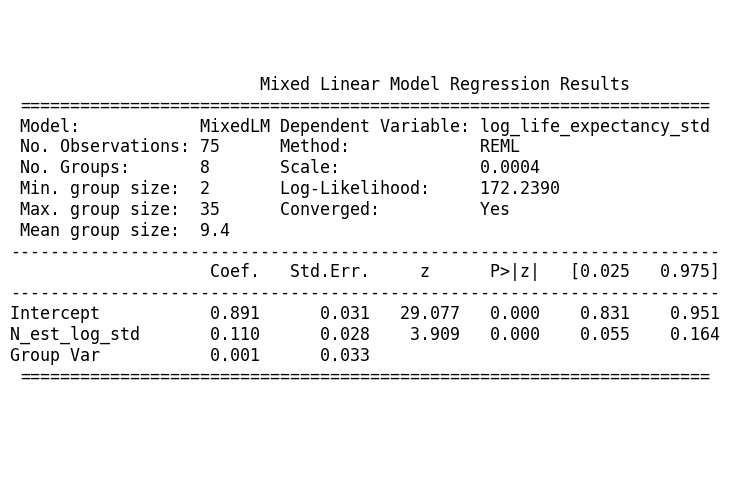

In [221]:
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

df_ols = df[['region_name', 'year', f'log_{var}_std', 'N_est_log_std', 'score_log_std']].copy()

# Mixed Effects Model
model = smf.mixedlm(f"log_{var}_std ~ N_est_log_std", df_ols, groups=df_ols["region_name"])
result = model.fit()


sm_table = result.summary().tables[1]
sm_table.index = ['Intercept', 'alpha', 'Group Var']
sm_table['model'] = 'Corrected CPI'
sm_table = sm_table.reset_index()


# Output model summary to get R-square values if available (typically for OLS, not directly for MixedLM)
print(result.summary())


# Plotting the summary text
fig, ax = plt.subplots(figsize=(8, 6))
ax.text(0.5, 0.5, result.summary(), fontsize=12, va='center', ha='center', fontname='Monospace')
ax.axis('off')  # Turn off the axis

/var/folders/lx/9b13r6ln63jb54_3xlf9b_380000gn/T/ipykernel_6089/2205678226.py:19: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot(x_vals, y_vals, 'k--', color=color_map[name], label=None)
/var/folders/lx/9b13r6ln63jb54_3xlf9b_380000gn/T/ipykernel_6089/2205678226.py:19: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot(x_vals, y_vals, 'k--', color=color_map[name], label=None)
/var/folders/lx/9b13r6ln63jb54_3xlf9b_380000gn/T/ipykernel_6089/2205678226.py:19: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot(x_vals, y_vals, 'k--', color=color_map[name], label=None)
/var/folders/lx/9b13r6ln63jb54_3xlf9b_380000gn/T/ipykernel_6089/220567822

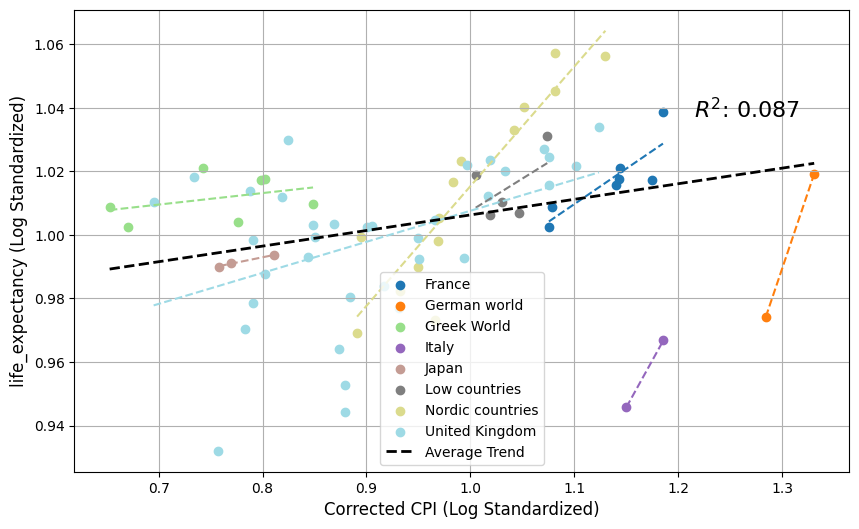

In [222]:
cmap = plt.get_cmap('tab20')
unique_regions = df_ols['region_name'].unique()
colors = cmap(np.linspace(0, 1, len(unique_regions)))
color_map = dict(zip(unique_regions, colors))

plt.figure(figsize=(10, 6))

# Plot individual data points and fit a regression line for each region
for name, group in df_ols.groupby('region_name'):
    # Fit OLS model for each region
    individual_ols_model = smf.ols(f"log_{var}_std ~ N_est_log_std", data=group).fit()
    
    # Plotting the scatter for each group
    plt.scatter(group['N_est_log_std'], group[f'log_{var}_std'], color=color_map[name], label=name)
    
    # Calculating the regression line
    x_vals = np.linspace(group['N_est_log_std'].min(), group['N_est_log_std'].max(), 100)
    y_vals = individual_ols_model.params['Intercept'] + individual_ols_model.params['N_est_log_std'] * x_vals
    plt.plot(x_vals, y_vals, 'k--', color=color_map[name], label=None)

# Fit a global OLS model to get the average trend line
average_ols_model = smf.ols(f"log_{var}_std ~ N_est_log_std", data=df_ols).fit()

# Calculate and plot the average trend line
x_vals_global = np.linspace(df_ols['N_est_log_std'].min(), df_ols['N_est_log_std'].max(), 100)
y_vals_global = average_ols_model.params['Intercept'] + average_ols_model.params['N_est_log_std'] * x_vals_global
plt.plot(x_vals_global, y_vals_global, 'k--', label='Average Trend', linewidth=2)

plt.legend()
plt.xlabel('Corrected CPI (Log Standardized)', fontsize=12)
plt.ylabel(f'{var} (Log Standardized)', fontsize=12)
plt.title('')
plt.grid(True)

# Display R-squared for the average trend line
r_squared = average_ols_model.rsquared
plt.figtext(0.85, 0.7, f'$R^2$: {r_squared:.3f}', ha='right', fontsize=16)

plt.show()

### Make Regression Table

In [223]:
import matplotlib.pyplot as plt
import pandas as pd


# Assuming the dataframe 'df_ols' is correctly set up from previous examples and ready to use
# Fit Mixed Effects Model (with region as a random effect)
mixed_model = smf.mixedlm(f"log_{var}_std ~ N_est_log_std", df_ols, groups=df_ols["region_name"])
result_mixed = mixed_model.fit()

# Fit OLS Model (without fixed effects)
ols_model = smf.ols(f"log_{var}_std ~ N_est_log_std", df_ols)
result_ols = ols_model.fit()


# Calculate the correlation coefficient for the OLS model (without fixed effects)
correlation_ols = df_ols['N_est_log_std'].corr(df_ols[f"log_{var}_std"])

# Calculate correlation coefficients for each group in the mixed effects model and take the average
grouped = df_ols.groupby('region_name')
correlation_mixed = grouped.apply(lambda g: g['N_est_log_std'].corr(g[f"log_{var}_std"])).mean()


# Calculate R-squared for OLS model
r_squared_ols = result_ols.rsquared


full_var = f"log_{var}_std"

# Assuming the model results and other variables (correlation_ols, correlation_mixed, etc.) are already available
results_df = pd.DataFrame({
    'Model': ['OLS Without FE', 'MixedLM With FE'],
    'Intercept': [f"{result_ols.params['Intercept']:.2f} ({result_ols.bse['Intercept']:.2f})", 
                  f"{result_mixed.params['Intercept']:.2f} ({result_mixed.bse['Intercept']:.2f})"],
    f'{var} Coef': [f"{result_ols.params['N_est_log_std']:.2f} ({result_ols.bse['N_est_log_std']:.2f})", 
                 f"{result_mixed.params['N_est_log_std']:.2f} ({result_mixed.bse['N_est_log_std']:.2f})"],
    f'{var} p-value': [f"{result_ols.pvalues['N_est_log_std']:.3f}", f"{result_mixed.pvalues['N_est_log_std']:.3f}"],
    'Log-Likelihood': [f"{result_ols.llf:.2f}", f"{result_mixed.llf:.2f}"],
    f'{var} Correlation': [f"{correlation_ols:.2f}", f"{correlation_mixed:.2f}"],
    'N': [f"{result_ols.nobs:.0f}", f"{result_mixed.nobs:.0f}"],
    'R-squared': [f"{result_ols.rsquared:.2f}", "N/A"]
})

# Transpose the DataFrame for the desired format
results_df = results_df.T
results_df.columns = results_df.iloc[0]  # Set the first row as column headers
results_df = results_df[1:]  # Remove the first row as it's now redundant

results_df.to_csv(f'df_indicators_hdi/regression_table_{var}.csv')

results_df


/Users/charlesdedampierre/Desktop/cultura_project/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


Model,OLS Without FE,MixedLM With FE
Intercept,0.96 (0.02),0.89 (0.03)
life_expectancy Coef,0.05 (0.02),0.11 (0.03)
life_expectancy p-value,0.010,0.000
Log-Likelihood,175.61,172.24
life_expectancy Correlation,0.30,0.76
N,75,75
R-squared,0.09,N/A


### GDP per capita

                Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: log_life_expectancy_std
No. Observations: 73      Method:             REML                   
No. Groups:       8       Scale:              0.0004                 
Min. group size:  1       Log-Likelihood:     169.1289               
Max. group size:  35      Converged:          Yes                    
Mean group size:  9.1                                                
------------------------------------------------------------------------
                Coef.    Std.Err.      z       P>|z|    [0.025    0.975]
------------------------------------------------------------------------
Intercept       0.732       0.064    11.414    0.000     0.606     0.857
log_gdp_std     0.269       0.063     4.273    0.000     0.146     0.393
Group Var       0.000       0.014                                       



/Users/charlesdedampierre/Desktop/cultura_project/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


(0.0, 1.0, 0.0, 1.0)

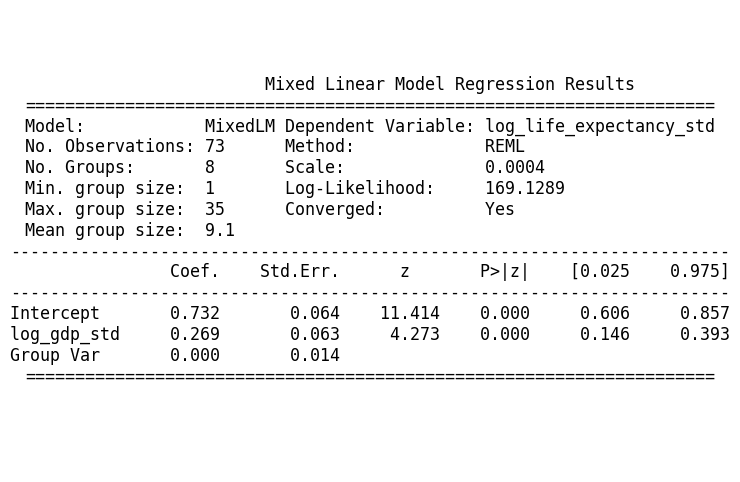

In [224]:
df_gdp = pd.read_csv("other_data/gdp_weighted_pop_decade.csv")
df_gdp = df_gdp.rename(columns={"region": "region_name", "decade":"year",'gdp_pc_weighted':'gdp_per_capita'})

new_df = pd.merge(df, df_gdp, on = ["region_name","year"])
new_df["log_gdp"] = np.log(new_df["gdp_per_capita"])
new_df["log_gdp_std"] = new_df["log_gdp"] / new_df["log_gdp"].mean()


df_ols = new_df[['region_name', 'year', f'log_{var}_std', 'log_gdp_std']].copy()

# Mixed Effects Model
model = smf.mixedlm(f"log_{var}_std ~ log_gdp_std", df_ols, groups=df_ols["region_name"])
result_gdp = model.fit()

sm_table_gdp = result_gdp.summary().tables[1]
sm_table_gdp.index = ['Intercept', 'alpha', 'Group Var']
sm_table_gdp['model'] = 'Corrected CPI'
sm_table_gdp = sm_table_gdp.reset_index()

# Output model summary to get R-square values if available (typically for OLS, not directly for MixedLM)
print(result_gdp.summary())


# Plotting the summary text
fig, ax = plt.subplots(figsize=(8, 6))
ax.text(0.5, 0.5, result_gdp.summary(), fontsize=12, va='center', ha='center', fontname='Monospace')
ax.axis('off')  # Turn off the axis

<!-- ### Load Culture -->

In [225]:
# Fit a global OLS model to get the average trend line
average_ols_model_gdp = smf.ols(f"log_{var}_std ~ log_gdp_std", data=df_ols).fit()

# Display R-squared for the average trend line
r_squared_gdp = average_ols_model_gdp.rsquared

dict_indicator = []

n_obs = int(result.summary().tables[0].iloc[1][1])
n_obs_gdp =  int(result_gdp.summary().tables[0].iloc[1][1])

dict_indicator.append({'indicator':var, 
                       'coeff_indicator':sm_table.iloc[1]['Coef.'], 
                       'p_value_indicator':sm_table.iloc[1]['P>|z|'], 
                        'r2_indicator':r_squared,
                       'N_indicator':n_obs,
                       'coeff_gdp':sm_table_gdp.iloc[1]['Coef.'],
                       'p_value_gdp':sm_table_gdp.iloc[1]['P>|z|'], 
                        'p_value_gdp':sm_table_gdp.iloc[1]['P>|z|'],
                        'r2_gdp':r_squared_gdp, 
                        'N_gdp':n_obs_gdp}
                       )
final_table = pd.DataFrame(dict_indicator)
final_table.to_csv(f'df_indicators_hdi/{var}.csv')
final_table


,indicator,coeff_indicator,p_value_indicator,r2_indicator,N_indicator,coeff_gdp,p_value_gdp,r2_gdp,N_gdp
0,life_expectancy,0.110,0.000,0.087298,75,0.269,0.000,0.090518,73
